# Athena Rationales Empirical Visualization
Large Scale Empirical Analysis 

In [1]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

pd.options.display.float_format = '{:.2f}'.format

In [2]:
from tokenizers import ByteLevelBPETokenizer
import torch
import importlib
from fairseq.models.transformer import TransformerModel

In [3]:
import warnings
from matplotlib import colors
import os
from rationalization import rationalize_lm, rationalize_conditional_model

In [4]:
def param_default():
    corpus_fm = 'fm'
    corpus_fm_fc = 'fm_fc'
    corpus_fm_fc_co = 'fm_fc_co'
    corpus_fm_fc_ms = 'fm_fc_ms'
    corpus_fm_fc_ms_ff = 'fm_fc_ms_ff' #<-- Scope
    
    corpora = [ corpus_fm, corpus_fm_fc, corpus_fm_fc_co, corpus_fm_fc_ms, corpus_fm_fc_ms_ff ]

    #data_path = Path('../whole-dateset/corpus/' + corpus + '/')
    data_path_raw_corpora = [ Path('../whole-dateset/corpus/' + corpus + '/raw/') for corpus in corpora ]
    tokenizer_path = Path('../tokenizer/')
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [ [data_path_raw / 'eval/input.methods.txt', data_path_raw / 'eval/output.tests.txt'] for data_path_raw in data_path_raw_corpora] ,
        'test_raw': [ [data_path_raw / 'test/input.methods.txt', data_path_raw / 'test/output.tests.txt'] for data_path_raw in data_path_raw_corpora] ,
        'train_raw': [ [data_path_raw / 'train/input.methods.txt', data_path_raw / 'train/output.tests.txt'] for data_path_raw in data_path_raw_corpora],
        'data_labels' : ['test_raw'],#['eval_raw','test_raw','train_raw'], <----- Just Test
        #'output_pandas' : data_path / 'pandas/',
        'out_processed' : '/datasets/out_processed/',
        'model_name_or_path' : 'models/checkpoint_dir_01/models/', #Model Path
        'checkpoint_file': 'checkpoint_best.pt', #Model
        'data_preprocessed':'/home/davidna/data/dummy/sequential-rationales/fairseq/fairseq/data-bin/bins/',
        'output_results' : 'results/',
        'corpora': corpora 
    }

In [5]:
params = param_default()
params['output_results']

'results/'

In [6]:
params['eval_raw']

[[PosixPath('../whole-dateset/corpus/fm/raw/eval/input.methods.txt'),
  PosixPath('../whole-dateset/corpus/fm/raw/eval/output.tests.txt')],
 [PosixPath('../whole-dateset/corpus/fm_fc/raw/eval/input.methods.txt'),
  PosixPath('../whole-dateset/corpus/fm_fc/raw/eval/output.tests.txt')],
 [PosixPath('../whole-dateset/corpus/fm_fc_co/raw/eval/input.methods.txt'),
  PosixPath('../whole-dateset/corpus/fm_fc_co/raw/eval/output.tests.txt')],
 [PosixPath('../whole-dateset/corpus/fm_fc_ms/raw/eval/input.methods.txt'),
  PosixPath('../whole-dateset/corpus/fm_fc_ms/raw/eval/output.tests.txt')],
 [PosixPath('../whole-dateset/corpus/fm_fc_ms_ff/raw/eval/input.methods.txt'),
  PosixPath('../whole-dateset/corpus/fm_fc_ms_ff/raw/eval/output.tests.txt')]]

In [7]:
sns.set_theme(style="darkgrid")

## Universal Tokenizer

In [8]:
def load_tokenizer(bpe_path):
    return ByteLevelBPETokenizer(str(bpe_path)+'-vocab.json',str(bpe_path)+'-merges.txt')

In [9]:
def lazy_decode(bpe_java):
    return bpe_java.replace(' ','').replace('Ġ',' ').replace('Ċ','\n')

In [10]:
def prettify_java(minified_java):
    "tries to undo Michele's minification. Works decently, although for loops and sets get newlines inserted, and there are no empty lines or comments"
    minified_java = minified_java.replace('{','{\n').replace('}','}\n').replace(';',';\n')
    num_indents = 0
    pretty_java = ''
    for line in minified_java.splitlines():
        if line.lstrip().startswith('}'):
            num_indents -= 1
        pretty_java += num_indents*'    '+line+'\n'
        if line.endswith('{'):
            num_indents += 1
        if line.endswith('}') and not line.lstrip().startswith('}'):
            num_indents -= 1
    return pretty_java

In [11]:
tokenizer = load_tokenizer(params['bpe_path'])

# Loading Generated Code From Trials

In [12]:
df_generated_output = pd.read_json( params['output_results']  + '1_generation_[max:100]_02.json' ) 

In [13]:
df_generated_output.head(1)

,index,test_raw0,test_raw_bpe0,method_size0,0,1,2,3,4,5,...,21,22,23,24,25,26,27,28,29,source_sampling
0,3610,CitizenId implements Identity { @Override publ...,"[C, itizen, Id, Ġimplements, ĠIdentity, Ġ{, Ġ@...",96,"[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...",...,"[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 4...","[1039, 34603, 285, 13842, 8218, 1215, 17276, 1...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 28754, 1215, 17276, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[1039, 34603, 285, 13842, 1296, 20320, 32890, ...","[347, 31020, 28081, 36987, 30805, 25522, 787, ..."


# Loading Rationales From Trials

In [14]:
#Loading one trial
df_rationale_output = pd.read_json( params['output_results'] + 'rationales_1_gen_02/' + 'rationales_[t_1000]_[max_src_100]_[max_tgt_100]_02_[exp:0]_.json' ) 

In [15]:
df_rationale_output.head(2) ##All Rationales for each sample

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
0,Test,0,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[]
1,Ġpublic,0,"[[Test, 0.9563337564000001]]",[],[1],[],[0.9563337564000001],[]


In [16]:
#tst
df_rationale_output[df_rationale_output['from_seq_id'] == 999 ]

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src
63616,Test,999,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[]
63617,Ġpublic,999,"[[Test, 0.9563337564000001]]",[],[1],[],[0.9563337564000001],[]
63618,Ġvoid,999,"[[Ġpublic, 0.999979496]]",[],[2],[],[0.999979496],[]
63619,Ġtest,999,"[[Ġvoid, 0.9145835638]]",[],[3],[],[0.9145835638],[]
63620,E,999,"[[Ġtest, 0.0015851373]]","[[Ġescape, 0.0424372219], [(, 0.4725152254]]",[4],"[58, 59]",[0.0015851373],"[0.0424372219, 0.4725152254]"
...,...,...,...,...,...,...,...,...
63677,(,999,"[[escape, 0.1820134521]]","[[(, 0.6593741179]]",[61],[8],[0.1820134521],[0.6593741179]
63678,null,999,"[[(, 0.018699348]]","[[Ġnull, 0.9097349048000001]]",[62],[17],[0.018699348],[0.9097349048000001]
63679,));,999,"[[null, 0.059247039300000005]]","[[</s>, 0.21295756100000002], [), 0.3896539509]]",[63],"[80, 18]",[0.059247039300000005],"[0.21295756100000002, 0.3896539509]"
63680,Ġ},999,"[[));, 0.1826504469], [null, 0.9831843972000001]]",[],"[64, 13]",[],"[0.1826504469, 0.9831843972000001]",[]


In [17]:
df_rationale_output.shape

(63682, 8)

# Loading Context Windows

In [18]:
#export
def method_size_vector( method_vector ):
    '''Return the size of the tokens for a give method based on id
        Assuming that method_vector is an array of tokens
    '''
    input_ids = [ len(mtd) for mtd in method_vector ]
    return input_ids

In [19]:
def super_set_code():
    data = {}
    for label in params['data_labels']:
        corpora = params['corpora']
        for i,path_data in enumerate(params[ label ]):

            print(i,corpora[i],path_data[0])
            name = label + str('_input_') + corpora[i]
            df = pd.read_csv( path_data[0], sep="\n", header=None, names=[ name ] ) #reading file
            df[ label + '_bpe_' + str('_input_') + corpora[i]] = [ enc.tokens for enc in tokenizer.encode_batch( df[ name ].values ) ] #bpe
            df['method_size'+ str('_input_') + corpora[i]] = method_size_vector( df[label + '_bpe_' + str('_input_') + corpora[i]].values ) #counting tokens
            data[ name ] =  df  
        #data[-1].columns = [ label ]
    return data

In [20]:
super_data = super_set_code()

0 fm ../whole-dateset/corpus/fm/raw/test/input.methods.txt
1 fm_fc ../whole-dateset/corpus/fm_fc/raw/test/input.methods.txt
2 fm_fc_co ../whole-dateset/corpus/fm_fc_co/raw/test/input.methods.txt
3 fm_fc_ms ../whole-dateset/corpus/fm_fc_ms/raw/test/input.methods.txt
4 fm_fc_ms_ff ../whole-dateset/corpus/fm_fc_ms_ff/raw/test/input.methods.txt


In [21]:
flat_result = pd.concat(super_data, axis=1)
flat_result.head(1)

test_raw_input_fm  \
                                   test_raw_input_fm   
0  public static Date yearStart() { final Gregori...   

                                                                           \
                              test_raw_bpe__input_fm method_size_input_fm   
0  [public, Ġstatic, ĠDate, Ġyear, Start, (), Ġ{,...                   42   

                                test_raw_input_fm_fc  \
                                test_raw_input_fm_fc   
0  DateUtils { public static Date yearStart() { f...   

                                                                              \
                           test_raw_bpe__input_fm_fc method_size_input_fm_fc   
0  [Date, Ut, ils, Ġ{, Ġpublic, Ġstatic, ĠDate, Ġ...                      47   

                             test_raw_input_fm_fc_co  \
                             test_raw_input_fm_fc_co   
0  DateUtils { public static Date yearStart() { f...   

                                                      \
                        test_raw_bpe__input_fm_fc_co   
0  [Date, Ut, ils, Ġ{, Ġpublic, Ġstatic, ĠDate, Ġ...   

                              \
  method_size_input_fm_fc_co   
0                         47   

                             test_raw_input_fm_fc_ms  \
                             test_raw_input_fm_fc_ms   
0  DateUtils { public static Date yearStart() { f...   

                                                      \
                        test_raw_bpe__input_fm_fc_ms   
0  [Date, Ut, ils, Ġ{, Ġpublic, Ġstatic, ĠDate, Ġ...   

                              \
  method_size_input_fm_fc_ms   
0                        227   

                          test_raw_input_fm_fc_ms_ff  \
                          test_raw_input_fm_fc_ms_ff   
0  DateUtils { public static Date yearStart() { f...   

                                                      \
                     test_raw_bpe__input_fm_fc_ms_ff   
0  [Date, Ut, ils, Ġ{, Ġpublic, Ġstatic, ĠDate, Ġ...   

                                 
  method_size_input_fm_fc_ms_ff  
0                           227

In [22]:
flat_result.shape

(78388, 15)

In [23]:
df_indexes = pd.DataFrame()
df_indexes[['fm','fm_fc','fm_fc_co','fm_fc_ms','fm_fc_ms_ff']] = flat_result[[
    ('test_raw_input_fm','method_size_input_fm'),
    ('test_raw_input_fm_fc', 'method_size_input_fm_fc'),
    ('test_raw_input_fm_fc_co', 'method_size_input_fm_fc_co'),
    ('test_raw_input_fm_fc_ms', 'method_size_input_fm_fc_ms'),
    ('test_raw_input_fm_fc_ms_ff', 'method_size_input_fm_fc_ms_ff')
    ]].copy()
df_indexes['fm_fc__fm'] =  df_indexes['fm_fc'].values - df_indexes['fm']

In [24]:
df_indexes.head(1)

,fm,fm_fc,fm_fc_co,fm_fc_ms,fm_fc_ms_ff,fm_fc__fm
0,42,47,47,227,227,5


In [25]:
df_index_filtered = df_indexes.filter(
    items = df_generated_output['index'].values,
    axis = 0
).copy()
df_index_filtered = df_index_filtered.reset_index()

In [26]:
df_index_filtered.shape

(1000, 7)

In [27]:
df_index_filtered

,index,fm,fm_fc,fm_fc_co,fm_fc_ms,fm_fc_ms_ff,fm_fc__fm
0,3610,31,38,44,96,96,7
1,23609,32,57,57,70,70,25
2,45764,25,30,30,95,95,5
3,6263,29,36,36,55,55,7
4,29527,70,72,88,88,88,2
...,...,...,...,...,...,...,...
995,44112,30,35,54,97,97,5
996,44261,30,35,54,97,97,5
997,27410,26,36,54,94,94,10
998,16185,34,44,55,100,100,10


# Processing and Identifying Context Windows

In [28]:
#A function that recieves an array of indexes and return the context windows of such token
def context_level(arr_index, seq_id, df_index_guide = df_index_filtered):
    context_levels = ['class', 'focal_method', 'constructors', 'method_sig', 'fields']
    context_level_out = []
    for i in arr_index:
        if 0 <= i and i <= df_index_guide.loc[seq_id].fm_fc__fm: #class
            context_level_out.append( context_levels[0] )
        elif df_index_guide.loc[seq_id].fm_fc__fm <= i and i <= df_index_guide.loc[seq_id].fm_fc: #focal method
            context_level_out.append( context_levels[1] )
        elif df_index_guide.loc[seq_id].fm_fc <= i and i <= df_index_guide.loc[seq_id].fm_fc_co: #constructors
            context_level_out.append( context_levels[2] )
        elif df_index_guide.loc[seq_id].fm_fc_co <= i and i <= df_index_guide.loc[seq_id].fm_fc_ms: #method signatures
            context_level_out.append( context_levels[3] )
        elif df_index_guide.loc[seq_id].fm_fc_ms <= i and i <= df_index_guide.loc[seq_id].fm_fc_ms_ff: #fields
            context_level_out.append( context_levels[4] )
        else:
            context_level_out.append( None )
    return context_level_out


In [29]:
#tst
context_level_out = context_level(
    arr_index = [58, 59],
    seq_id = 999
)
context_level_out

['method_sig', 'method_sig']

In [30]:
#WARINING !! TIME CONSUMING ~33.8s
df_rationale_output['context_src'] = [ context_level( 
    arr_index = df_rationale_output.loc[index].rationale_pos_src, 
    seq_id =  df_rationale_output.loc[index].from_seq_id
    ) for index in df_rationale_output.index ] 

In [31]:
df_rationale_output[df_rationale_output['from_seq_id'] == 999 ]

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,context_src
63616,Test,999,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[],[]
63617,Ġpublic,999,"[[Test, 0.9563337564000001]]",[],[1],[],[0.9563337564000001],[],[]
63618,Ġvoid,999,"[[Ġpublic, 0.999979496]]",[],[2],[],[0.999979496],[],[]
63619,Ġtest,999,"[[Ġvoid, 0.9145835638]]",[],[3],[],[0.9145835638],[],[]
63620,E,999,"[[Ġtest, 0.0015851373]]","[[Ġescape, 0.0424372219], [(, 0.4725152254]]",[4],"[58, 59]",[0.0015851373],"[0.0424372219, 0.4725152254]","[method_sig, method_sig]"
...,...,...,...,...,...,...,...,...,...
63677,(,999,"[[escape, 0.1820134521]]","[[(, 0.6593741179]]",[61],[8],[0.1820134521],[0.6593741179],[focal_method]
63678,null,999,"[[(, 0.018699348]]","[[Ġnull, 0.9097349048000001]]",[62],[17],[0.018699348],[0.9097349048000001],[focal_method]
63679,));,999,"[[null, 0.059247039300000005]]","[[</s>, 0.21295756100000002], [), 0.3896539509]]",[63],"[80, 18]",[0.059247039300000005],"[0.21295756100000002, 0.3896539509]","[fields, focal_method]"
63680,Ġ},999,"[[));, 0.1826504469], [null, 0.9831843972000001]]",[],"[64, 13]",[],"[0.1826504469, 0.9831843972000001]",[],[]


# Statistics: Average Influence of Context Windows on Token Predictions
General Analysis of the influence (or importance) of context windows to next token predictions

In [32]:
context_levels = ['class', 'focal_method', 'constructors', 'method_sig', 'fields']

In [33]:
dict_context_levels = {k:[] for k in context_levels} #Correct Way of Initializing a dictionary!, please verify

In [34]:
#Finding and appending context level rationales
for index in df_rationale_output.index:
    for indx, arr_context in enumerate(df_rationale_output.loc[index].context_src):
        dict_context_levels[arr_context].append( df_rationale_output.loc[index].rationale_prob_src[indx] )

In [35]:
all_tokens = functools.reduce( lambda a, b: a + b, [len(i) for i in dict_context_levels.values()] )
weights_context_levels = [ len(i)/all_tokens for i in dict_context_levels.values() ] #Level of importance

In [36]:
weights_context_levels

[0.14457575918172663,
 0.5004239758333775,
 0.12356245693995442,
 0.22444220679421273,
 0.006995601250728708]

In [37]:
dict_context_levels_weighted = {key: np.array(dict_context_levels[key])*weights_context_levels[i] for i,key in  enumerate(dict_context_levels)}

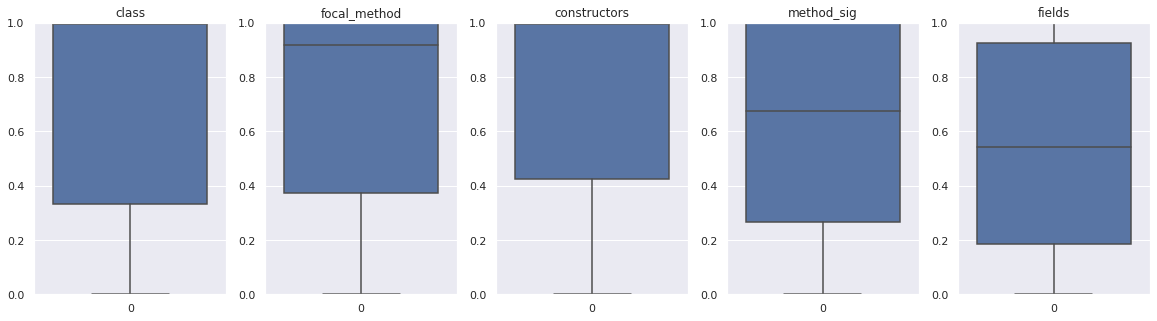

In [38]:
fig, axs = plt.subplots( figsize=(20,5), ncols=5 )
for i,key in enumerate(dict_context_levels):
    axs[i].set_ylim(0, 1)
    sns.boxplot(data=dict_context_levels[key], showfliers=False,ax=axs[i]).set_title(key)

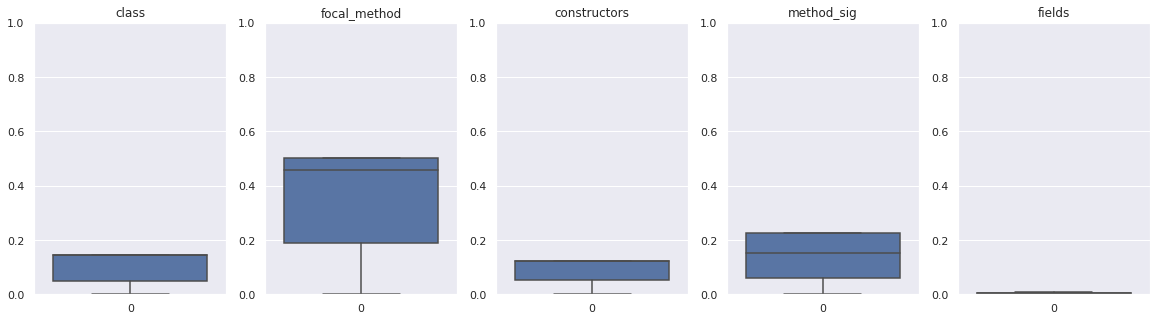

In [39]:
fig, axs = plt.subplots( figsize=(20,5), ncols=5 )
for i,key in enumerate(dict_context_levels_weighted):
    axs[i].set_ylim(0, 1)
    sns.boxplot(data=dict_context_levels_weighted[key], showfliers=False,ax=axs[i]).set_title(key)

In [40]:
for key in dict_context_levels.keys():
    row_arr = np.array(dict_context_levels[key])
    print(key)
    print( row_arr.size, row_arr.mean(), row_arr.std(), row_arr.max(), row_arr.min() )

class
5456 0.708836475413838 0.3897299091023628 0.9999995232000001 1.11594e-05
focal_method
18885 0.6956659531982525 0.36072771958854466 1.0 3.9354500000000004e-05
constructors
4663 0.7354030142553721 0.3570490881802944 0.9999997616 5.1085e-06
method_sig
8470 0.619548294429634 0.36799329196452446 0.9999997616 5.6993e-06
fields
264 0.5279557627640151 0.34678889722539835 0.9999988079000001 7.94681e-05


In [41]:
np.array(dict_context_levels['focal_method']).size

18885

## Bootstrapping Avg. Rationale Contribution per Context Level
Relative Contribution of Each Context Window

In [42]:
from sklearn.utils import resample

In [43]:
N_SAMPLES_BOOT = 20000

In [44]:
context_level_boot = { context_level: resample(dict_context_levels_weighted[ context_level ], replace=True, n_samples=N_SAMPLES_BOOT, random_state=1) for context_level in dict_context_levels_weighted }
df_context_level_boot = pd.DataFrame.from_dict( context_level_boot )

In [45]:
df_context_level_boot.head(1)

,class,focal_method,constructors,method_sig,fields
0,0.14,0.50,0.12,0.09,0.01


<AxesSubplot:ylabel='Count'>

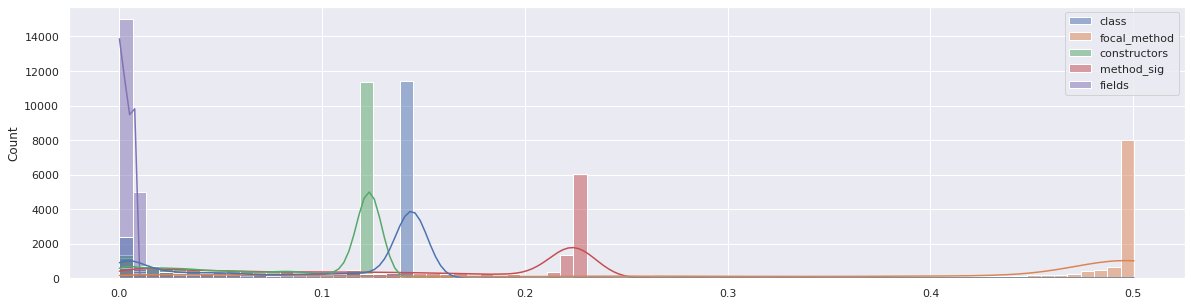

In [46]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(data=df_context_level_boot, kde=True, ax=ax) 

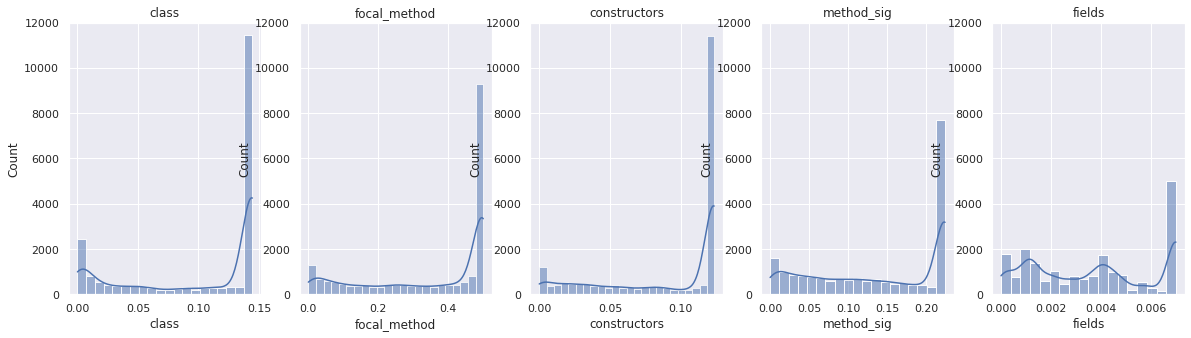

In [47]:
fig, axs = plt.subplots( figsize=(20,5), ncols=5 )
for i,key in enumerate(df_context_level_boot):
    #plt.figure(i)
    axs[i].set_ylim(0, 12000)
    sns.histplot(
        data=df_context_level_boot[key], 
        kde=True, 
        #log_scale=True, 
        ax=axs[i]
        ).set_title(key)

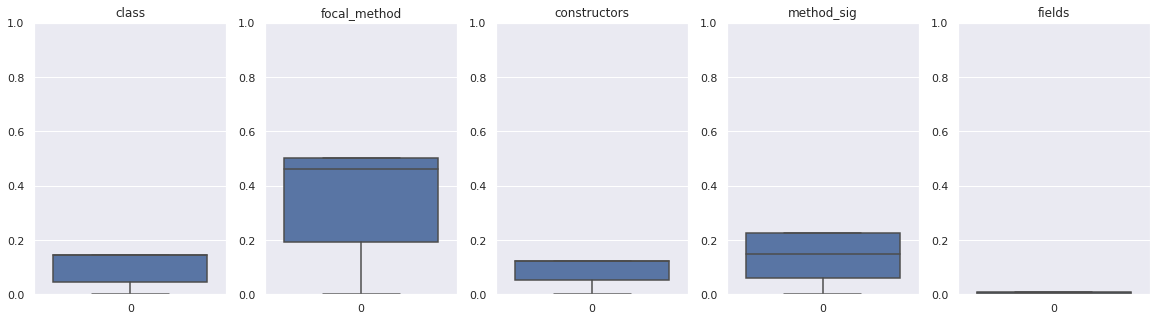

In [48]:
fig, axs = plt.subplots( figsize=(20,5), ncols=5 )
for i,key in enumerate(df_context_level_boot):
    axs[i].set_ylim(0, 1)
    sns.boxplot(data=df_context_level_boot[key], showfliers=False,ax=axs[i]).set_title(key)

## Rationales by General Taxonomy on Target and Context Level on Source

In [49]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [50]:
tkn_taxonomy = token_taxonomy()

In [51]:
tkn_taxonomy.keys()

dict_keys(['blocks', 'exceptions', 'oop', 'tests', 'declarations', 'conditionals', 'loops', 'operators', 'datatypes', 'extra_tokens'])

In [52]:
df_rationale_output.head()

,goal_token,from_seq_id,typesets_tgt,typesets_src,rationale_pos_tgt,rationale_pos_src,rationale_prob_tgt,rationale_prob_src,context_src
0,Test,0,"[[@, 0.9980469942]]",[],[0],[],[0.9980469942],[],[]
1,Ġpublic,0,"[[Test, 0.9563337564000001]]",[],[1],[],[0.9563337564000001],[],[]
2,Ġvoid,0,"[[Ġpublic, 0.999979496]]",[],[2],[],[0.999979496],[],[]
3,Ġtest,0,"[[Ġvoid, 0.9145835638]]",[],[3],[],[0.9145835638],[],[]
4,Val,0,"[[Ġtest, 0.0028000718]]","[[Ġvalidate, 0.0896889865], [Number, 0.9335296...",[4],"[10, 22]",[0.0028000718],"[0.0896889865, 0.9335296750000001]","[focal_method, focal_method]"


In [53]:
def extracting_rationales_by_context(non_stringent = True):
    dict_ccp_by_context = {k:{l:[] for l in context_levels } for k in tkn_taxonomy.keys() } #DataStructure To Aggregate Ratioanales
    dict_set_elems = { category: set( tkn_taxonomy[category].values() ) for category in tkn_taxonomy.keys() } #Set of Categories
    if non_stringent:
        dict_set_elems = { category : dict_set_elems[category].union( set(['Ġ'+tok_elem for tok_elem in dict_set_elems[category]]) ) for category in tkn_taxonomy.keys() }
    for row in df_rationale_output.index: #Iterating by rows
        for category in dict_set_elems.keys(): #Iterating by CCP
            if df_rationale_output.loc[row].goal_token in dict_set_elems[category]:
                for indx, contex in enumerate(df_rationale_output.loc[row].context_src): #Iterating Context
                    dict_ccp_by_context[ category ][ contex ].append( df_rationale_output.loc[row].rationale_prob_src[indx] )
                break
    return dict_ccp_by_context

In [54]:
dict_ccp_by_context = extracting_rationales_by_context() #Time Consuming

In [55]:
def reducing_rationales(dict_ccp_by_context = dict_ccp_by_context, agg_f = np.mean):
    #Independent Variable: Source Rows [contex level]
    #Dependent Variable: Target Columns [taxonomies]
    np_rationales = np.zeros(
                    ( len( tkn_taxonomy.keys() ), len( context_levels ) ) )
    for i, row_tax in enumerate( dict_ccp_by_context ):
        dict_inner = dict_ccp_by_context[row_tax]
        #print(i)
        if dict_inner: #if is not empty
            #print(i)
            for j, column_context in enumerate( dict_inner ):
                #print(j)
                list_tax = dict_inner[column_context]
                if list_tax:
                    np_rationales[i][j] = agg_f( list_tax ) #Agregation Function
    return np_rationales

In [56]:
np_rationales_avg = reducing_rationales(agg_f = np.mean)
np_rationales_max = reducing_rationales(agg_f = np.max)
np_rationales_min = reducing_rationales(agg_f = np.min)

In [57]:
np_rationales_avg

array([[0.50315878, 0.61113628, 0.63728849, 0.66712434, 0.49517457],
       [0.59506757, 0.74211495, 0.57341999, 0.6261153 , 0.        ],
       [0.47172151, 0.5048615 , 0.48289213, 0.34038973, 0.        ],
       [0.31636807, 0.47887178, 0.46683535, 0.54890396, 0.2401695 ],
       [0.66262538, 0.504347  , 0.82697111, 0.60789216, 0.98933077],
       [0.38508374, 0.3287089 , 0.67287703, 0.71937097, 0.        ],
       [0.35734328, 0.51066135, 0.32566318, 0.32627022, 0.        ],
       [0.22533966, 0.43165642, 0.2914346 , 0.35235953, 0.        ],
       [0.99311999, 0.97785697, 0.66994604, 0.84087921, 0.        ],
       [0.71464682, 0.66924705, 0.99224263, 0.18219014, 0.        ]])

In [58]:
def print_heatmap(
    np_rationales, 
    fig_size = (10,10), 
    font = 15,
    yticklabels = list( tkn_taxonomy.keys() ), 
    xticklabels = context_levels
    ):
        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(np_rationales, cmap="YlGnBu", 
                yticklabels=yticklabels, 
                xticklabels=xticklabels,
                ax=ax)
        plt.show
        pass

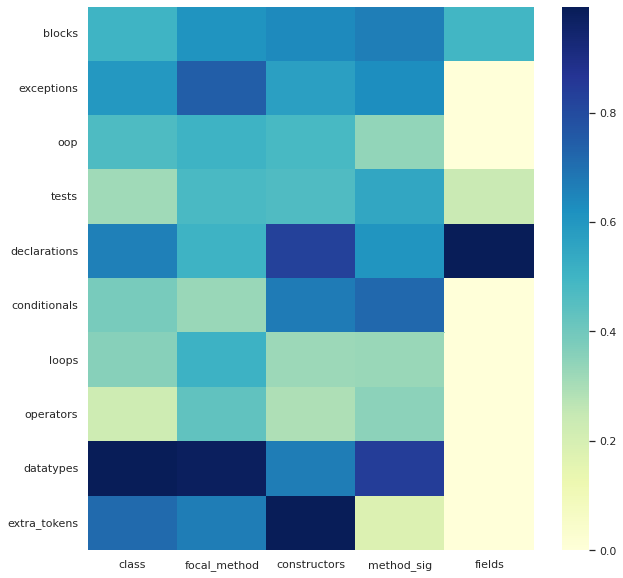

Bad pipe message: %s [b'&"\xbb\x1f\xb5@\x05j\xc8o\xd5\xe7\xccoW\x1d(\xb4 \x08A\xc9d\x07CO(VQ+o\xff*\xce\xae\x84-R\x86j\xaa\xa9\xf2\xb8bWh\x89\xf18\xd8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 ']
Bad pipe message: %s [b'.\xba|A\xc3\xea\xc4\x85\x16\xc8\x11\x81\xfd\x88y']
Bad pipe message: %s [b'\x00 \xdcbOr\xf3\xe5\x0bLtWM\xf5eu?\x93\xe7]%`\xc6\xaf\xd3\xc4\xa5\xbc\xd5\x1d\\\x12\xc5\xfb\x00\x08\x13\x02\x13\x03\x13']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'{\x12\x97\xd2\x1b\x0fO\xf1ax\xda\xf7\xad[\x9e)\x1b\xf1\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc', b"\xaa\xc0\xaf\xc0\xad\xc0\xa3

In [62]:
print_heatmap(
    np_rationales = np_rationales_avg, 
    fig_size = (10,10), 
    font = 15
    )

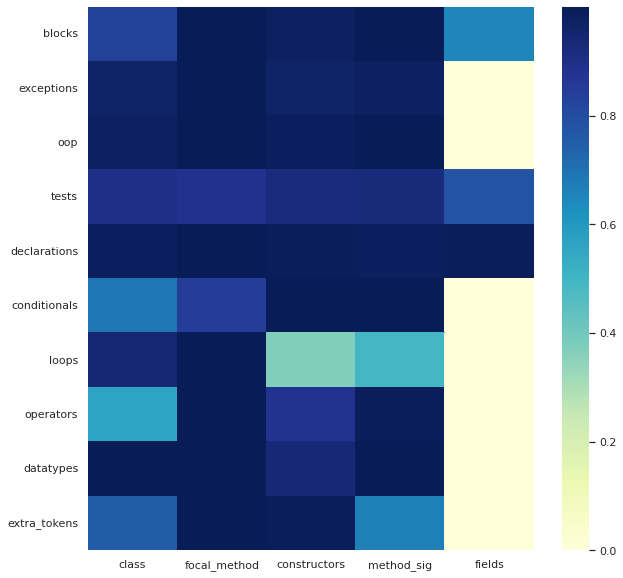

In [60]:
print_heatmap(
    np_rationales = np_rationales_max, 
    fig_size = (10,10), 
    font = 15
    )

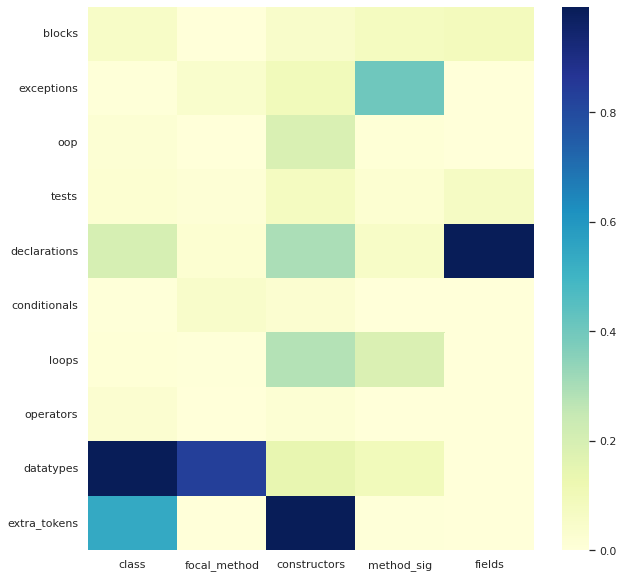

In [61]:
print_heatmap(
    np_rationales = np_rationales_min, 
    fig_size = (10,10), 
    font = 15
    )